## Уровень 1 — Подключения

Выполняется в final_homework.
 Подключиться к серверу Trino из Jupyter Notebook (настроить Python-
клиент, параметры хоста/порта/каталога).
 Проверить доступность каталога PostgreSQL в Trino:
 вывести список схем;
 вывести список таблиц хотя бы в одной схеме (например, SHOW
SCHEMAS, SHOW TABLES).
 Аналогично проверить доступность каталога MySQL: список схем и таблиц.

In [134]:
!pip install trino
!pip install pandas
!pip install matplotlib

In [135]:
from trino.dbapi import connect

conn = connect(
    host='localhost',
    port=8080,
    user='trino',
    catalog='iceberg',
    schema='default',
    http_scheme='http'
)

cursor = conn.cursor()
print("Connected")


Connected


In [136]:
cursor.execute("SHOW SCHEMAS FROM postgresql")
schemas_pg = cursor.fetchall()

print("Schemas from postgresql:")
for schema in schemas_pg:
    print(schema[0])

cursor.execute("SHOW TABLES FROM postgresql.public")
tables_pg = cursor.fetchall()

print("\nTables from postgresql.public:")
for table in tables_pg:
    print(table[0])


Schemas from postgresql:
information_schema
pg_catalog
public

Tables from postgresql.public:
city
country
country_flag
country_language


In [137]:
cursor.execute("SHOW SCHEMAS FROM mysql")
schemas_mysql = cursor.fetchall()

print("Schemas from mysql:")
for schema in schemas_mysql:
    print(schema[0])

cursor.execute("SHOW TABLES FROM mysql.sakila")
tables_mysql = cursor.fetchall()

print("\nTables from mysql.sakila:")
for table in tables_mysql:
    print(table[0])


Schemas from mysql:
information_schema
performance_schema
sakila

Tables from mysql.sakila:
actor
actor_info
address
category
city
country
customer
customer_list
film
film_actor
film_category
film_list
film_text
inventory
language
nicer_but_slower_film_list
payment
rental
sales_by_film_category
sales_by_store
staff
staff_list
store


# Для postgres

## Уровень 2 — Агрегация данных

 Выбрать одну или несколько таблиц в PostgreSQL и/или MySQL,
содержащие числовые или датовые поля (например, заказы, транзакции,
метрики).
 Сформировать и выполнить минимум два агрегирующих SQL-запроса
через Trino, например:
 группировки по дате, клиенту, категории;
 подсчет количества записей, суммирование, средние значения;
 top-N по какому-либо показателю.
 Загрузить результаты этих агрегирующих запросов в pandas DataFrame.
 На основе полученных DataFrame сформировать финальный
агрегированный DataFrame, который будет использоваться и для
визуализации, и для сохранения в Iceberg.

1. Population by cities and countris
2. Continent analysis

In [138]:
import pandas as pd

query1 = """
SELECT 
    country.name as country_name,
    country.continent,
    COUNT(city.id) as city_count,
    SUM(city.population) as total_city_population,
    country.population as country_population
FROM postgresql.public.country
JOIN postgresql.public.city ON country.code = city.country_code
GROUP BY country.name, country.continent, country.population
HAVING COUNT(city.id) > 5
ORDER BY city_count DESC
LIMIT 30
"""

cursor.execute(query1)
results = cursor.fetchall()
cols = [d[0] for d in cursor.description]

df_countries = pd.DataFrame(results, columns=cols)
print(f"Countries count: {len(df_countries)}")
print(df_countries.head())

print("Stats:")
print(df_countries.describe())

Countries count: 30
    country_name      continent  city_count  total_city_population  \
0          China           Asia         363              175953614   
1          India           Asia         341              123298526   
2  United States  North America         274               78625774   
3         Brazil  South America         250               85876862   
4          Japan           Asia         248               77965107   

   country_population  
0          1277558000  
1          1013662000  
2           278357000  
3           170115000  
4           126714000  
Stats:
       city_count  total_city_population  country_population
count   30.000000           3.000000e+01        3.000000e+01
mean   105.966667           3.779899e+07        1.513369e+08
std     95.918242           3.821851e+07        2.791811e+08
min     29.000000           7.469006e+06        1.521100e+07
25%     44.000000           1.511436e+07        3.967552e+07
50%     60.500000           2.134383e+07  

In [139]:
query2 = """
SELECT 
    continent,
    COUNT(DISTINCT code) as country_count,
    SUM(population) as total_population,
    AVG(population) as avg_population,
    SUM(gnp) as total_gnp,
    AVG(life_expectancy) as avg_life
FROM postgresql.public.country
WHERE population > 0
GROUP BY continent
ORDER BY total_population DESC
"""

cursor.execute(query2)
res = cursor.fetchall()
columns = [d[0] for d in cursor.description]

df_continents = pd.DataFrame(res, columns=columns)
print(f"\nContinents: {len(df_continents)}")
print(df_continents)


Continents: 6
       continent  country_count  total_population  avg_population   total_gnp  \
0           Asia             51        3705025700    7.264756e+07  7655392.00   
1         Africa             57         784475000    1.376272e+07   580375.00   
2         Europe             46         730074600    1.587119e+07  9498865.00   
3  North America             37         482993000    1.305386e+07  9688627.20   
4  South America             14         345780000    2.469857e+07  1511874.00   
5        Oceania             27          30401150    1.125969e+06   419774.70   

    avg_life  
0  67.441180  
1  52.571930  
2  75.147730  
3  72.991890  
4  70.946150  
5  69.715004  


In [140]:
df_countries['data_source'] = 'countries'
df_continents['data_source'] = 'continents'

df1 = df_countries[['country_name', 'city_count', 'total_city_population', 'data_source']].copy()
df1.columns = ['dimension', 'metric1', 'metric2', 'source']

df2 = df_continents[['continent', 'country_count', 'total_population', 'data_source']].copy()
df2.columns = ['dimension', 'metric1', 'metric2', 'source']

df_final = pd.concat([df1, df2], ignore_index=True)

print(f"\nfinal df: {len(df_final)}")
print(f"Columns: {list(df_final.columns)}")
df_final.head(10)


final df: 36
Columns: ['dimension', 'metric1', 'metric2', 'source']


,dimension,metric1,metric2,source
0,China,363,175953614,countries
1,India,341,123298526,countries
2,United States,274,78625774,countries
3,Brazil,250,85876862,countries
4,Japan,248,77965107,countries
5,Russian Federation,189,69150700,countries
6,Mexico,173,59752521,countries
7,Philippines,136,30934791,countries
8,Germany,93,26245483,countries
9,Indonesia,85,37485695,countries


## Уровень 3 — Визуализация и Iceberg

Визуализация:
 Построить минимум два графика по агрегированным данным, например:
 график по датам (линейный или столбчатый);
 график распределения (гистограмма, boxplot и т. п.).
 Оформить графики:
 задать осмысленные подписи осей;
 добавить заголовки, при необходимости легенду.

Сохранение данных в Iceberg: final_homework.pdf
 Создать собственную схему в каталоге Iceberg (если она еще не создана).
 Создать Iceberg-таблицу для финального агрегированного DataFrame (задать
структуру полей).
 Сохранить агрегированные данные в эту таблицу (через Trino/SQL или
доступный способ интеграции).
 Выполнить SQL-запрос через Trino к созданной Iceberg-таблице и вывести
результат в ноутбуке для проверки содержимого.

### Plots:
1. Countries with the most cities
2. Population by continents
3. Connection between population and cities count

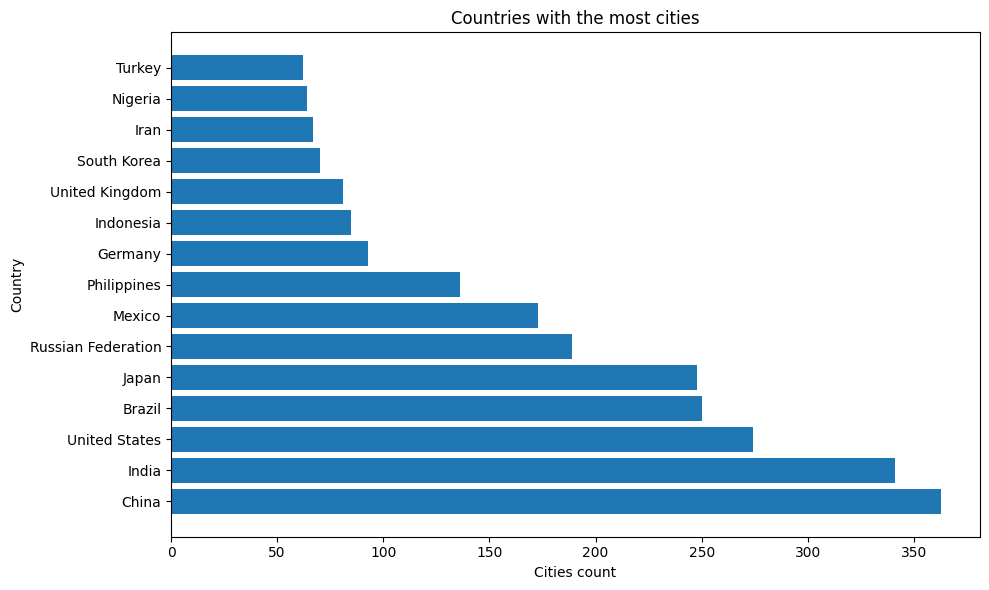

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

top15 = df_countries.head(15)
plt.barh(top15['country_name'], top15['city_count'])
plt.xlabel('Cities count')
plt.ylabel('Country')
plt.title('Countries with the most cities')
plt.tight_layout()
plt.show()


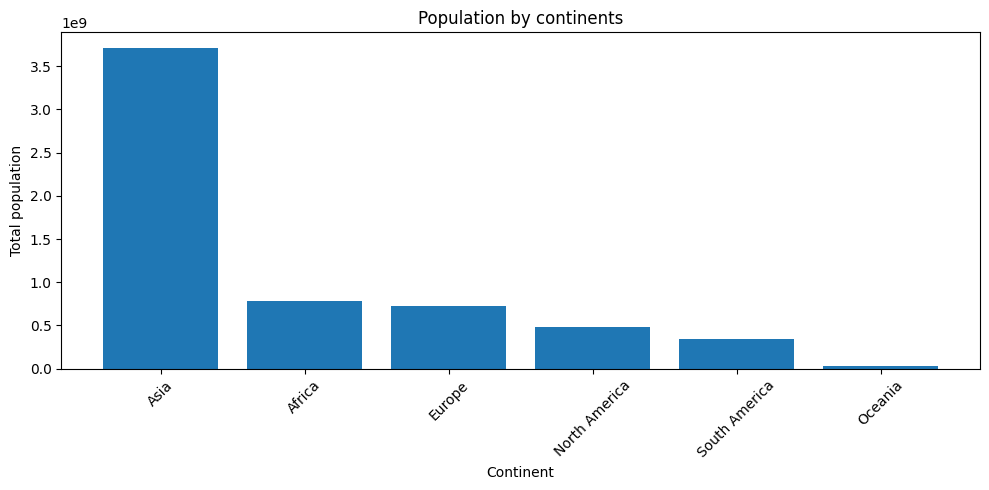

In [142]:
plt.figure(figsize=(10, 5))

plt.bar(df_continents['continent'], df_continents['total_population'])
plt.xlabel('Continent')
plt.ylabel('Total population')
plt.title('Population by continents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

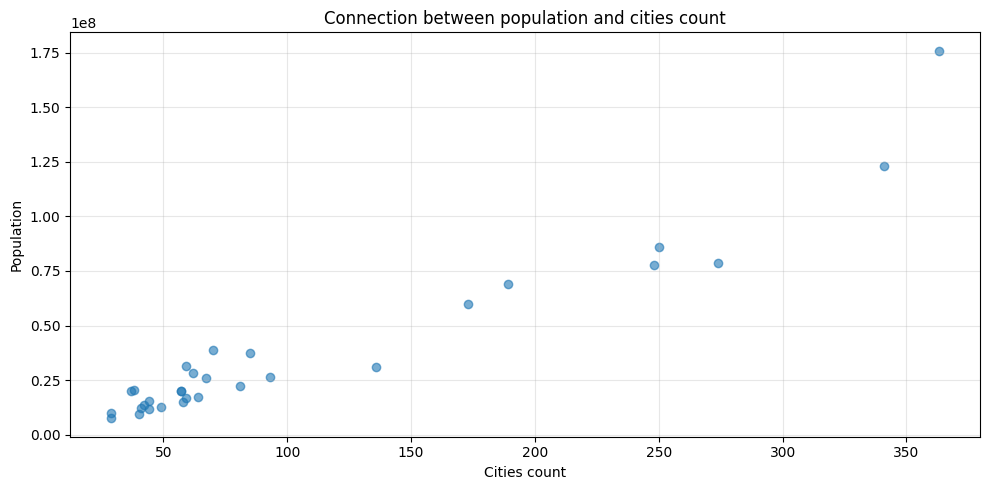

In [143]:
plt.figure(figsize=(10, 5))

plt.scatter(df_countries['city_count'], 
            df_countries['total_city_population'],
            alpha=0.6)
plt.xlabel('Cities count')
plt.ylabel('Population')
plt.title('Connection between population and cities count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Iceberg

In [144]:
schema_name = 'world_analytics'

try:
    cursor.execute(f"CREATE SCHEMA IF NOT EXISTS iceberg.{schema_name}")
    print(f"Created: {schema_name}")
except Exception as e:
    print(f"Error: {e}")

cursor.execute("SHOW SCHEMAS FROM iceberg")
schemas = cursor.fetchall()

print("\nIceberg schemas:")
for s in schemas:
    print(s[0])

Created: world_analytics

Iceberg schemas:
films_analytics
information_schema
system
world_analytics


In [145]:
table_name = 'country_stats'

try:
    cursor.execute(f"DROP TABLE IF EXISTS iceberg.{schema_name}.{table_name}")
    print("Removed old table if exists")
except:
    pass

create_sql = f"""
CREATE TABLE iceberg.{schema_name}.{table_name} (
    analysis_date DATE,
    country_name VARCHAR,
    continent VARCHAR,
    city_count BIGINT,
    total_population BIGINT,
    data_type VARCHAR,
    created_timestamp DATE
)
"""

try:
    cursor.execute(create_sql)
    print(f"Created: {table_name}")
except Exception as e:
    print(f"Error: {e}")

Removed old table if exists
Created: country_stats


In [146]:
cursor.execute(f"DESCRIBE iceberg.{schema_name}.{table_name}")
struct = cursor.fetchall()

print("Structure:")
for s in struct:
    print(f"{s[0]}: {s[1]}")

Structure:
analysis_date: date
country_name: varchar
continent: varchar
city_count: bigint
total_population: bigint
data_type: varchar
created_timestamp: date


In [147]:
# countries

from datetime import datetime

count = 0
for i, row in df_countries.iterrows():
    country_clean = row['country_name'].replace("'", "''")
    
    insert_sql = f"""
    INSERT INTO iceberg.{schema_name}.{table_name}
    VALUES (
        CURRENT_DATE,
        '{country_clean}',
        '{row['continent']}',
        {row['city_count']},
        {row['total_city_population']},
        'country_detail',
        TIMESTAMP '{datetime.now()}'
    )
    """
    cursor.execute(insert_sql)
    count += 1

print(f"Inserted {count} rows by countries")

Inserted 30 rows by countries


In [148]:
# continents

count = 0
for i, row in df_continents.iterrows():
    insert_sql = f"""
    INSERT INTO iceberg.{schema_name}.{table_name}
    VALUES (
        CURRENT_DATE,
        'CONTINENT_TOTAL',
        '{row['continent']}',
        {row['country_count']},
        {row['total_population']},
        'continent_summary',
        TIMESTAMP '{datetime.now()}'
    )
    """
    cursor.execute(insert_sql)
    count += 1

print(f"Inserted {count} rows by continents")

Inserted 6 rows by continents


In [149]:
check_sql = f"""
SELECT 
    data_type,
    COUNT(*) as record_count,
    SUM(city_count) as total_cities,
    SUM(total_population) as total_pop
FROM iceberg.{schema_name}.{table_name}
GROUP BY data_type
"""

cursor.execute(check_sql)
res = cursor.fetchall()
df_check = pd.DataFrame(res, columns=['type', 'records', 'cities', 'population'])

print("Checking data:")
print(df_check)

Checking data:
                type  records  cities  population
0     country_detail       30    3179  1133969680
1  continent_summary        6     232  6078749450


In [150]:
check_last = f"""
SELECT *
FROM iceberg.{schema_name}.{table_name}
ORDER BY created_timestamp DESC
LIMIT 10
"""

cursor.execute(check_last)
res = cursor.fetchall()
cols = [d[0] for d in cursor.description]
df_last = pd.DataFrame(res, columns=cols)

print("\nLast rows:")
print(df_last)


Last rows:
  analysis_date     country_name      continent  city_count  total_population  \
0    2026-01-07            Italy         Europe          58          15087019   
1    2026-01-07          Ukraine         Europe          57          20074000   
2    2026-01-07            Spain         Europe          59          16669189   
3    2026-01-07      South Korea           Asia          70          38999893   
4    2026-01-07           Mexico  North America         173          59752521   
5    2026-01-07  CONTINENT_TOTAL  North America          37         482993000   
6    2026-01-07           Poland         Europe          44          11687431   
7    2026-01-07            Egypt         Africa          37          20083079   
8    2026-01-07  CONTINENT_TOTAL           Asia          51        3705025700   
9    2026-01-07     South Africa         Africa          44          15196370   

           data_type created_timestamp  
0     country_detail        2026-01-07  
1     country_

In [151]:
check_continent = f"""
SELECT 
    continent,
    SUM(city_count) as cities,
    SUM(total_population) as population
FROM iceberg.{schema_name}.{table_name}
WHERE data_type = 'country_detail'
GROUP BY continent
ORDER BY population DESC
"""

cursor.execute(check_continent)
res = cursor.fetchall()
df_cont_check = pd.DataFrame(res, columns=['continent', 'cities', 'population'])

print("\nAggregation by continents from Iceberg:")
print(df_cont_check)


Aggregation by continents from Iceberg:
       continent  cities  population
0           Asia    1473   584113725
1         Europe     650   198063995
2  North America     496   151052135
3  South America     415   148093476
4         Africa     145    52646349


# Для mysql

## Уровень 2 — Агрегация данных

 Выбрать одну или несколько таблиц в PostgreSQL и/или MySQL,
содержащие числовые или датовые поля (например, заказы, транзакции,
метрики).
 Сформировать и выполнить минимум два агрегирующих SQL-запроса
через Trino, например:
 группировки по дате, клиенту, категории;
 подсчет количества записей, суммирование, средние значения;
 top-N по какому-либо показателю.
 Загрузить результаты этих агрегирующих запросов в pandas DataFrame.
 На основе полученных DataFrame сформировать финальный
агрегированный DataFrame, который будет использоваться и для
визуализации, и для сохранения в Iceberg.

1. Top 10 movies by revenue
2. Top 10 clients by payments

In [152]:
top_films = """
SELECT
  f.film_id,
  f.title,
  SUM(p.amount) as total_revenue
FROM mysql.sakila.payment p
JOIN mysql.sakila.rental r ON p.rental_id = r.rental_id
JOIN mysql.sakila.inventory i ON r.inventory_id = i.inventory_id
JOIN mysql.sakila.film f ON i.film_id = f.film_id
GROUP BY f.film_id, f.title
ORDER BY total_revenue DESC
LIMIT 10
"""

cursor.execute(top_films)
res = cursor.fetchall()
cols = [desc[0] for desc in cursor.description]
df_top_films = pd.DataFrame(res, columns=cols)

print("Top 10 movies by revenue:\n", df_top_films)

Top 10 movies by revenue:
    film_id              title total_revenue
0      879   TELEGRAPH VOYAGE        231.73
1      973          WIFE TURN        223.69
2     1000          ZORRO ARK        214.69
3      369  GOODFELLAS SALUTE        209.69
4      764     SATURDAY LAMBS        204.72
5      893        TITANS JERK        201.71
6      897       TORQUE BOUND        198.72
7      403        HARRY IDAHO        195.70
8      460     INNOCENT USUAL        191.74
9      444      HUSTLER PARTY        190.78


In [153]:
top_customers = """
SELECT
  cu.customer_id,
  cu.first_name,
  cu.last_name,
  COUNT(p.payment_id) as payments_count,
  SUM(p.amount) as total_payment
FROM mysql.sakila.payment p
JOIN mysql.sakila.customer cu ON p.customer_id = cu.customer_id
GROUP BY cu.customer_id, cu.first_name, cu.last_name
ORDER BY total_payment DESC
LIMIT 10
"""

cursor.execute(top_customers)
res = cursor.fetchall()
cols = [desc[0] for desc in cursor.description]
df_top_customers = pd.DataFrame(res, columns=cols)

print("Top 10 clients by payments:\n", df_top_customers)


Top 10 clients by payments:
    customer_id first_name last_name  payments_count total_payment
0          526       KARL      SEAL              45        221.55
1          148    ELEANOR      HUNT              46        216.54
2          144      CLARA      SHAW              42        195.58
3          178     MARION    SNYDER              39        194.61
4          137     RHONDA   KENNEDY              39        194.61
5          459      TOMMY   COLLAZO              38        186.62
6          469     WESLEY      BULL              40        177.60
7          468        TIM      CARY              39        175.61
8          236     MARCIA      DEAN              42        175.58
9          181        ANA   BRADLEY              34        174.66


In [154]:
df_top_films['data_type'] = 'film_revenue'
df_top_customers['data_type'] = 'customer_payment'

df_top_films['analysis_date'] = pd.Timestamp.now().date()
df_top_customers['analysis_date'] = pd.Timestamp.now().date()
df_top_films['created_timestamp'] = pd.Timestamp.now()
df_top_customers['created_timestamp'] = pd.Timestamp.now()

df_films_out = df_top_films[['analysis_date', 'film_id', 'title', 'total_revenue', 'data_type', 'created_timestamp']]
df_customers_out = df_top_customers[['analysis_date', 'customer_id', 'first_name', 'last_name', 'total_payment', 'data_type', 'created_timestamp']]


In [155]:
print(f"\nfinal films df: {len(df_films_out)}")
print(f"Films columns: {list(df_films_out.columns)}")
print(df_films_out.head(10))


final films df: 10
Films columns: ['analysis_date', 'film_id', 'title', 'total_revenue', 'data_type', 'created_timestamp']
  analysis_date  film_id              title total_revenue     data_type  \
0    2026-01-07      879   TELEGRAPH VOYAGE        231.73  film_revenue   
1    2026-01-07      973          WIFE TURN        223.69  film_revenue   
2    2026-01-07     1000          ZORRO ARK        214.69  film_revenue   
3    2026-01-07      369  GOODFELLAS SALUTE        209.69  film_revenue   
4    2026-01-07      764     SATURDAY LAMBS        204.72  film_revenue   
5    2026-01-07      893        TITANS JERK        201.71  film_revenue   
6    2026-01-07      897       TORQUE BOUND        198.72  film_revenue   
7    2026-01-07      403        HARRY IDAHO        195.70  film_revenue   
8    2026-01-07      460     INNOCENT USUAL        191.74  film_revenue   
9    2026-01-07      444      HUSTLER PARTY        190.78  film_revenue   

           created_timestamp  
0 2026-01-07 05:44:

In [156]:
print(f"\nclients films df: {len(df_customers_out)}")
print(f"Clients columns: {list(df_customers_out.columns)}")
print(df_customers_out.head(10))


clients films df: 10
Clients columns: ['analysis_date', 'customer_id', 'first_name', 'last_name', 'total_payment', 'data_type', 'created_timestamp']
  analysis_date  customer_id first_name last_name total_payment  \
0    2026-01-07          526       KARL      SEAL        221.55   
1    2026-01-07          148    ELEANOR      HUNT        216.54   
2    2026-01-07          144      CLARA      SHAW        195.58   
3    2026-01-07          178     MARION    SNYDER        194.61   
4    2026-01-07          137     RHONDA   KENNEDY        194.61   
5    2026-01-07          459      TOMMY   COLLAZO        186.62   
6    2026-01-07          469     WESLEY      BULL        177.60   
7    2026-01-07          468        TIM      CARY        175.61   
8    2026-01-07          236     MARCIA      DEAN        175.58   
9    2026-01-07          181        ANA   BRADLEY        174.66   

          data_type          created_timestamp  
0  customer_payment 2026-01-07 05:44:29.909499  
1  customer_pa

## Уровень 3 — Визуализация и Iceberg

Визуализация:
 Построить минимум два графика по агрегированным данным, например:
 график по датам (линейный или столбчатый);
 график распределения (гистограмма, boxplot и т. п.).
 Оформить графики:
 задать осмысленные подписи осей;
 добавить заголовки, при необходимости легенду.

Сохранение данных в Iceberg: final_homework.pdf
 Создать собственную схему в каталоге Iceberg (если она еще не создана).
 Создать Iceberg-таблицу для финального агрегированного DataFrame (задать
структуру полей).
 Сохранить агрегированные данные в эту таблицу (через Trino/SQL или
доступный способ интеграции).
 Выполнить SQL-запрос через Trino к созданной Iceberg-таблице и вывести
результат в ноутбуке для проверки содержимого.

### Plots:
1. Top 10 movies by revenue
2. Top 10 clients by payments

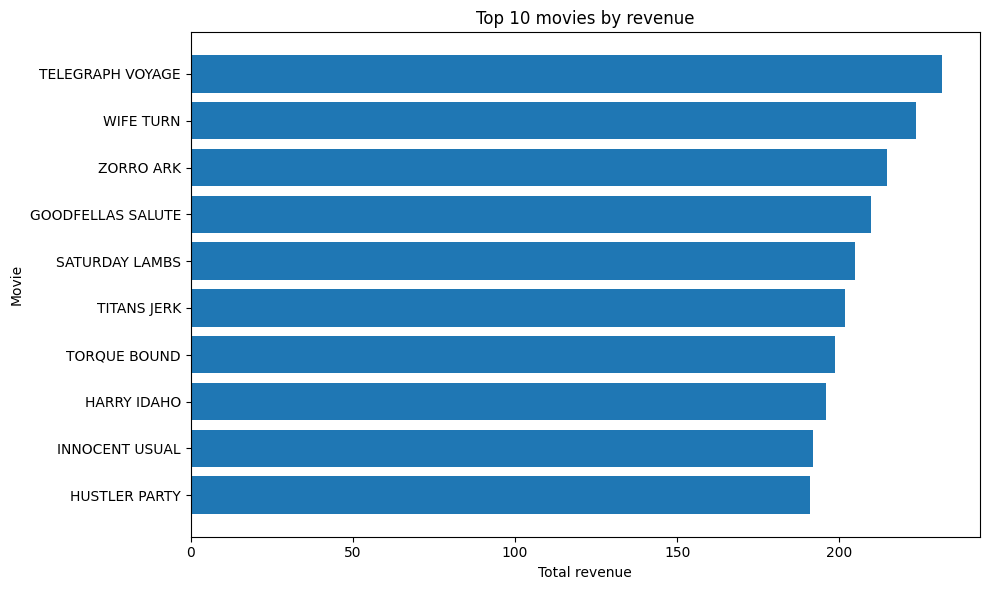

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_top_films['title'][::-1], df_top_films['total_revenue'][::-1])
plt.xlabel('Total revenue')
plt.ylabel('Movie')
plt.title('Top 10 movies by revenue')
plt.tight_layout()
plt.show()


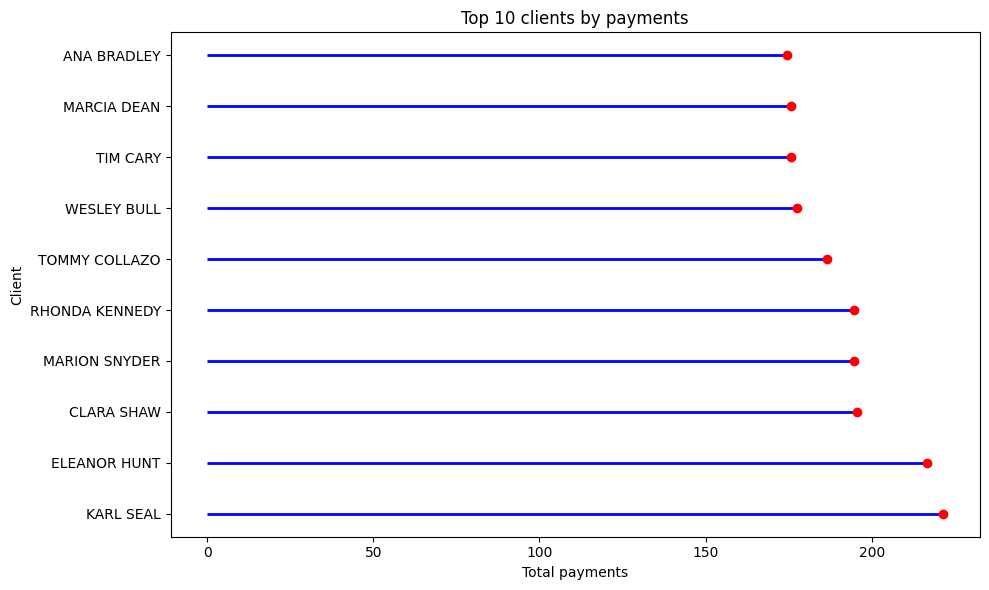

In [158]:
plt.figure(figsize=(10, 6))

y = df_top_customers['first_name'] + ' ' + df_top_customers['last_name']
x = df_top_customers['total_payment']
plt.hlines(y, xmin=0, xmax=x, color='blue', linewidth=2)
plt.plot(x, y, 'o', color='red')

plt.xlabel('Total payments')
plt.ylabel('Client')
plt.title('Top 10 clients by payments')
plt.tight_layout()
plt.show()


### Iceberg

In [159]:
films_schema_name = 'films_analytics'

try:
    cursor.execute(f"CREATE SCHEMA IF NOT EXISTS iceberg.{films_schema_name}")
    print(f"Created: {films_schema_name}")
except Exception as e:
    print(f"Error: {e}")

cursor.execute("SHOW SCHEMAS FROM iceberg")
schemas = cursor.fetchall()

print("\nIceberg schemas:")
for s in schemas:
    print(s[0])

Created: films_analytics

Iceberg schemas:
films_analytics
information_schema
system
world_analytics


In [160]:
films_table_name = 'films_stats'

try:
    cursor.execute(f"DROP TABLE IF EXISTS iceberg.{films_schema_name}.{films_table_name}")
    print("Removed old table if exists")
except:
    pass

create_sql = f"""
CREATE TABLE IF NOT EXISTS iceberg.{films_schema_name}.{films_table_name} (
    analysis_date DATE,
    group_id VARCHAR,
    group_text VARCHAR,
    metric_value DOUBLE,
    data_type VARCHAR,
    created_timestamp TIMESTAMP
)
"""

try:
    cursor.execute(create_sql)
    print(f"Created: {films_table_name}")
except Exception as e:
    print(f"Error: {e}")

Removed old table if exists
Created: films_stats


In [161]:
cursor.execute(f"DESCRIBE iceberg.{films_schema_name}.{films_table_name}")
struct = cursor.fetchall()

print("Structure:")
for s in struct:
    print(f"{s[0]}: {s[1]}")

Structure:
analysis_date: date
group_id: varchar
group_text: varchar
metric_value: double
data_type: varchar
created_timestamp: timestamp(6)


In [162]:
# films

count = 0
for i, row in df_films_out.iterrows():    
    insert_sql = f"""
    INSERT INTO iceberg.{films_schema_name}.{films_table_name}
    VALUES (
        DATE '{row['analysis_date']}',
        '{row['film_id']}',
        '{row['title'].replace("'", "''")}',
        {row['total_revenue']},
        '{row['data_type']}',
        TIMESTAMP '{row['created_timestamp']}'
    )
    """
    cursor.execute(insert_sql)
    count += 1

print(f"Inserted {count} rows by films")

Inserted 10 rows by films


In [163]:
# clients

count = 0
for i, row in df_customers_out.iterrows():    
    insert_sql = f"""
    INSERT INTO iceberg.{films_schema_name}.{films_table_name}
    VALUES (
        DATE '{row['analysis_date']}',
        '{row['customer_id']}',
        '{row['first_name']} {row['last_name']}',
        {row['total_payment']},
        '{row['data_type']}',
        TIMESTAMP '{row['created_timestamp']}'
    )
    """
    cursor.execute(insert_sql)
    count += 1

print(f"Inserted {count} rows by clients")

Inserted 10 rows by clients


In [164]:
check_sql = f"""
SELECT data_type, COUNT(*) as n, SUM(metric_value) as total
FROM iceberg.{films_schema_name}.{films_table_name}
GROUP BY data_type
"""
cursor.execute(check_sql)
res = cursor.fetchall()
print("Aggregation by types:\n", pd.DataFrame(res, columns=['type', 'records', 'total']))

Aggregation by types:
                type  records    total
0  customer_payment       10  1912.96
1      film_revenue       10  2063.17


In [165]:
check_last = f"""
SELECT *
FROM iceberg.{films_schema_name}.{films_table_name}
ORDER BY created_timestamp DESC
LIMIT 10
"""
cursor.execute(check_last)
df_check = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
print("Last rows:\n", df_check)

Last rows:
   analysis_date group_id      group_text  metric_value         data_type  \
0    2026-01-07      459   TOMMY COLLAZO        186.62  customer_payment   
1    2026-01-07      469     WESLEY BULL        177.60  customer_payment   
2    2026-01-07      468        TIM CARY        175.61  customer_payment   
3    2026-01-07      178   MARION SNYDER        194.61  customer_payment   
4    2026-01-07      181     ANA BRADLEY        174.66  customer_payment   
5    2026-01-07      144      CLARA SHAW        195.58  customer_payment   
6    2026-01-07      148    ELEANOR HUNT        216.54  customer_payment   
7    2026-01-07      137  RHONDA KENNEDY        194.61  customer_payment   
8    2026-01-07      526       KARL SEAL        221.55  customer_payment   
9    2026-01-07      236     MARCIA DEAN        175.58  customer_payment   

           created_timestamp  
0 2026-01-07 05:44:29.909499  
1 2026-01-07 05:44:29.909499  
2 2026-01-07 05:44:29.909499  
3 2026-01-07 05:44:29.90949